Время начала 14 35

Опустили латунь 14 37

Достали латунь 14 44

включили нагрев калориметра 14 47 (до 18.2)


остановили нагрев калориметра 15 09 (до 18.1)

температура упала на 1-2 градуса 15 20

опустили латунь 15 21

достали латунь опустили медь 15 23

включили нагрев меди 15 31 (было где то 17.4)

остановили нагрев меди 16 00

достали медь 16 15 

опустили латунь 16 18

опустили титан 16 21

греем с титаном 16 26

выключили нагрев 16 46 

In [319]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [320]:
def get_sec(time_str):
    """Get seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [321]:
def LeastSquares(x_arr, y_arr): # returns [k, b, sigma_k, sigma b]
    v = x_arr
    u = y_arr

    N = len(v)

    mu = np.mean(u) # средее
    mv = np.mean(v)
    mv2 = np.mean([v_i**2 for v_i in v]) # средний квадрат
    mu2 = np.mean([u_i**2 for u_i in u])
    muv = np.mean ([u[i] * v[i] for i in range(len(u))]) # среднее от произведения
    k = (muv - mu * mv) / (mv2 - mv**2)
    b = mu - k * mv

    sigma_k = np.sqrt(1/(N-2) * ( (mu2 - mu**2)/(mv2 - mv**2) - k**2 ) )
    sigma_b = sigma_k * np.sqrt(mv2)

    return (k, b, sigma_k, sigma_b)

In [322]:
class Experiment:
    def __init__(self, filename) -> None:
        self.df = pd.read_csv(filename)
        self.nlines = len(self.df.index) - 1
        self.av_room_temp = 23.52 + 273.15 # K
        # self.power = 0.7366 * 0.001 * 0.00594 * 0.001 # W
        self.power = 27.2 * 0.226 # W

        print(f"Class initialized (nlines = %d)" % (self.nlines))

    def read_time(self):
        self.time = [get_sec(self.df['Time'][i]) for i in range(1, self.nlines + 1)]
        print(f"Time[%d]" % (len(self.time)))
        # return self.time

    def read_temperature(self):
        self.resistance  = [self.df['Value'][i] for i in range(1, self.nlines + 1)]
        self.temperature = [14.583955001619313455*self.resistance[i] + 39.35514018691588785 for i in range(self.nlines)]
        print(f"Temperature[%d]" % (len(self.temperature)))
        # return self.temperature

    def calc_ln_temperatures(self, t_begin, t_end):
        ln_temperature = [math.log((self.temperature[i]- self.av_room_temp) /
                                        (self.temperature[t_begin] - self.av_room_temp)) for i in range(t_begin, t_end)]
        return range(t_begin, t_end), ln_temperature

    def calc_lambda(self, k, t_begin, t_end):
        lambdas = [self.power / (self.temperature[i] - self.av_room_temp) *
                    (1 - math.exp(-k * self.time[i - t_begin])) for i in range(t_begin, t_end)]
        return range(0, t_end - t_begin), lambdas

    def truncate_data(self, n_first):
        self.nlines      = self.nlines - n_first
        self.time        = self.time       [n_first:]
        self.time        = [self.time[i] - self.time[0] for i in range(self.nlines)]
        self.resistance  = self.resistance [n_first:]
        self.temperature = self.temperature[n_first:]
        print("Data successfully truncated")
        print("nlines = %d" % (self.nlines))

    def delete_measuremet_errors(self, sigma_max):
        cnt = 0
        for i in range(1, self.nlines - 1):
            if (self.temperature[i-1] + sigma_max < self.temperature[i] and
                self.temperature[i] > self.temperature[i+1] + sigma_max):
                print("popping dot [%d](%d, %d)" % (i, self.time[i], self.temperature[i]))
                self.time.pop(i)
                self.temperature.pop(i)
                self.resistance.pop(i)
                cnt += 1
        self.nlines -= cnt
        print("current nlines = %d" % (self.nlines))

In [323]:
Experiment = Experiment('data.csv')


Class initialized (nlines = 8877)


In [324]:
Experiment.read_time()
Experiment.read_temperature()
Experiment.truncate_data(750)
Experiment.delete_measuremet_errors(1)

Time[8877]
Temperature[8877]
Data successfully truncated
nlines = 8127
popping dot [1730](1736, 316)
current nlines = 8126


In [325]:
DELTA_T = 200

EMPTY_HEAT_BEGIN      = 368
EMPTY_HEAT_ROOM_TEMP  = 688
EMPTY_HEAT_STOP       = 1736
EMPTY_COOL_STOP       = 2447 # 2456

COPPER_HEAT_BEGIN     = 3058
COPPER_HEAT_ROOM_TEMP = 3456
COPPER_HEAT_STOP      = 4804
COPPER_COOL_STOP      = 5801 # 5820

TITAN_HEAT_BEGIN      = 6348
TITAN_HEAT_ROOM_TEMP  = 6628
TITAN_HEAT_STOP       = 7560
TITAN_COOL_STOP       = 8126 # 8153

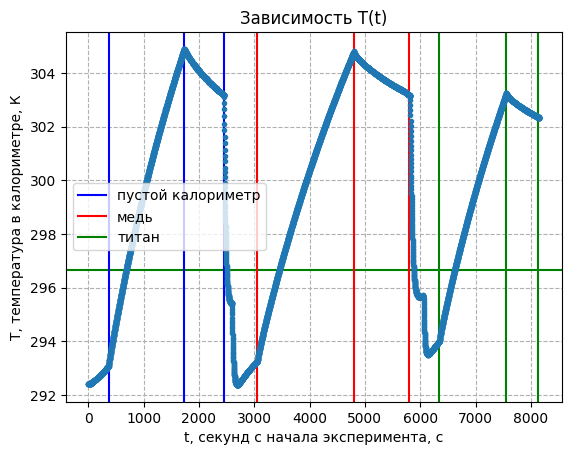

In [326]:
plt.figure()
plt.xlabel("t, секунд с начала эксперимента, с")
plt.ylabel("Т, температура в калориметре, К")
plt.title('Зависимость Т(t)')
plt.grid(True, linestyle = '--')
plt.errorbar(Experiment.time, Experiment.temperature, fmt=".")

plt.axhline(y = Experiment.av_room_temp, color = 'g')

plt.axvline(x = EMPTY_HEAT_BEGIN, color = 'b', label = 'пустой калориметр')
plt.axvline(x = EMPTY_HEAT_STOP,  color = 'b')
plt.axvline(x = EMPTY_COOL_STOP,  color = 'b')

plt.axvline(x = COPPER_HEAT_BEGIN, color = 'r', label = 'медь')
plt.axvline(x = COPPER_HEAT_STOP , color = 'r')
plt.axvline(x = COPPER_COOL_STOP , color = 'r')

plt.axvline(x = TITAN_HEAT_BEGIN, color = 'g', label = 'титан')
plt.axvline(x = TITAN_HEAT_STOP , color = 'g')
plt.axvline(x = TITAN_COOL_STOP , color = 'g')

plt.legend()
plt.show()

$$T_{cool}(t) = (T-T_k)e^{-\frac{\lambda}{C}t} + T_k$$

$$T_{heat}(t) = \frac{P}{\lambda}(1-e^{-\frac{\lambda}{C}t}) + T_k$$

#### Пустой калориметр

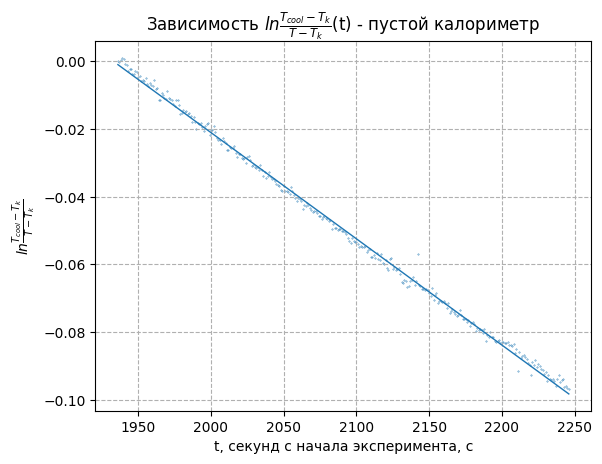

In [327]:
times, T_lns = Experiment.calc_ln_temperatures(EMPTY_HEAT_STOP + DELTA_T, EMPTY_COOL_STOP - DELTA_T)
plt.figure()
plt.xlabel("t, секунд с начала эксперимента, с")
plt.ylabel("$ln\\frac{T_{cool}-T_k}{T-T_k}$")
plt.title('Зависимость $ln\\frac{T_{cool}-T_k}{T-T_k}$(t) - пустой калориметр')
plt.grid(True, linestyle = '--')
plt.scatter(times, T_lns, s=.1)

k, b, kerr, berr = LeastSquares(times, T_lns)
x = np.array([min(times), max(times)])
plt.plot(x, k*x + b, "-", linewidth = 1)

plt.show()
k_empty = -k

#### Медь

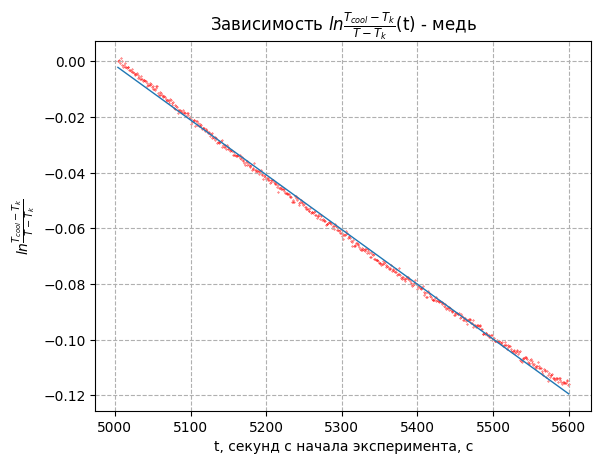

In [328]:
times, T_lns = Experiment.calc_ln_temperatures(COPPER_HEAT_STOP + DELTA_T, COPPER_COOL_STOP - DELTA_T)
plt.figure()
plt.xlabel("t, секунд с начала эксперимента, с")
plt.ylabel("$ln\\frac{T_{cool}-T_k}{T-T_k}$")
plt.title('Зависимость $ln\\frac{T_{cool}-T_k}{T-T_k}$(t) - медь')
plt.grid(True, linestyle = '--')
plt.scatter(times, T_lns, s=.1, color = 'r')

k, b, kerr, berr = LeastSquares(times, T_lns)
x = np.array([min(times), max(times)])
plt.plot(x, k*x + b, "-", linewidth = 1)

plt.show()
k_copper = -k

#### Титан

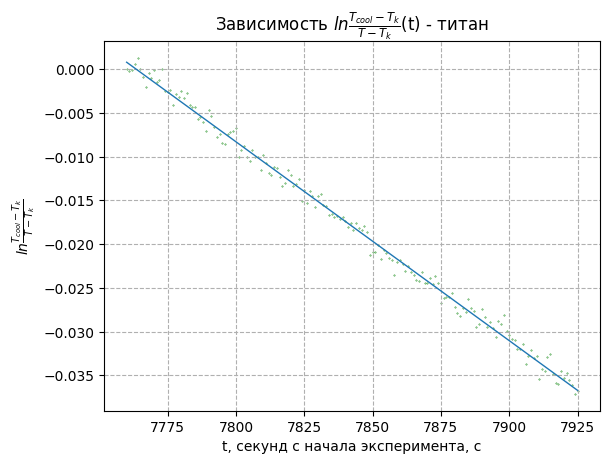

In [329]:
times, T_lns = Experiment.calc_ln_temperatures(TITAN_HEAT_STOP + DELTA_T, TITAN_COOL_STOP - DELTA_T)
plt.figure()
plt.xlabel("t, секунд с начала эксперимента, с")
plt.ylabel("$ln\\frac{T_{cool}-T_k}{T-T_k}$")
plt.title('Зависимость $ln\\frac{T_{cool}-T_k}{T-T_k}$(t) - титан')
plt.grid(True, linestyle = '--')
plt.scatter(times, T_lns, s=.1, color = 'g')

k, b, kerr, berr = LeastSquares(times, T_lns)
x = np.array([min(times), max(times)])
plt.plot(x, k*x + b, "-", linewidth = 1)

plt.show()
k_titan = -k

In [330]:
k_empty, k_copper, k_titan

(0.0003133802998412669, 0.0001966826409860552, 0.00022744770877779392)